# Fama-French portfolio sorts

- Value and size effect
- Bivariate portfolio sorts
- Fama-French research factors: HML, SMB, Mom, STRev

Copyright 2022, Terence Lim

MIT License

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from finds.database import SQL, Redis
from finds.structured import CRSP, Signals, Benchmarks, PSTAT, famafrench_sorts
from finds.backtesting import BackTest
from finds.busday import BusDay
from finds.recipes import fractiles
from finds.display import plot_date, plot_scatter, plot_hist, show
from tqdm import tqdm
from conf import credentials, VERBOSE, paths, CRSP_DATE

LAST_DATE = CRSP_DATE
%matplotlib inline
VERBOSE = 0
SHOW = dict(ndigits=4, latex=None)

imgdir = paths['images']
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)

rdb = Redis(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
bench = Benchmarks(sql, bd)
signals = Signals(user)

## Construct HML and SMB signal
- load items from Compustat Annual
- Construct HML as shareholders equity plus investment tax credits, 
   less preferred stock, divided by December market cap.
- Require 6 month reporting lag and at least two years history in Compustat

In [3]:
label = 'hml'
lag = 6               # number of months to lag fundamental data

# retrieve data fields from compustat, linked by permno
df = pstat.get_linked(dataset = 'annual',
                      date_field = 'datadate',
                      fields = ['seq', 'pstk', 'pstkrv', 'pstkl', 'txditc'],
                      where = ("indfmt = 'INDL'"
                               "  AND datafmt = 'STD'"
                               "  AND curcd = 'USD' "
                               "  AND popsrc = 'D'"
                               "  AND consol = 'C'"
                               "  AND seq > 0 "))

# subtract preferred stock, add back deferred investment tax credit
df[label] = np.where(df['pstkrv'].isna(), df['pstkl'], df['pstkrv'])
df[label] = np.where(df[label].isna(), df['pstk'], df[label])
df[label] = np.where(df[label].isna(), 0, df[label])
df[label] = df['seq'] + df['txditc'].fillna(0) - df[label]
df.dropna(subset = [label], inplace=True)
df = df[df[label] > 0][['permno', 'gvkey', 'datadate', label]]

# count years in Compustat        
df = df.sort_values(by=['gvkey','datadate'])
df['count'] = df.groupby(['gvkey']).cumcount()   

# construct b/m ratio
df['rebaldate'] = 0
for datadate in tqdm(sorted(df['datadate'].unique())):
    f = df['datadate'].eq(datadate)
    rebaldate = crsp.bd.endmo(datadate, abs(lag)) # 6 month lag
    capdate = crsp.bd.endyr(datadate)   # Dec mktcap
    if rebaldate >= LAST_DATE or capdate >= LAST_DATE:
        continue
    df.loc[f, 'rebaldate'] = rebaldate
    df.loc[f, 'cap'] = crsp.get_cap(capdate).reindex(df.loc[f, 'permno']).values
df[label] /= df['cap']
df = df[df[label].gt(0) & df['count'].gt(1)]  # 2+ years in Compustat
signals.write(df, label)

100%|████████████████████████████████████████| 728/728 [00:01<00:00, 365.70it/s]


216295

### helpers to show histograms and comparisons of portfolio returns

In [4]:
def plot_ff(y, label, savefig=None):
    """helper to scatter plot and compare portfolio returns"""
    y = y.rename(columns={'excess': label})
    corr = np.corrcoef(y, rowvar=False)[0,1]
    fig, (ax1, ax2) = plt.subplots(2, 1, clear=True, figsize=(5, 5))
    plot_date(y, ax=ax1, title=" vs ".join(y.columns), fontsize=7)
    plot_scatter(y.iloc[:,0], y.iloc[:,1], ax=ax2, abline=False, fontsize=7)
    plt.legend([f"corr={corr:.4f}"], fontsize=8)
    plt.tight_layout(pad=0.5)
    if savefig:
        plt.savefig(imgdir / savefig)
    print(f"<Correlation of {label} vs {benchname}"
          f" ({y.index[0]} - {y.index[-1]}): {corr:.4f}")

def plot_summary(y, label, savefig=None):
    """helper to plot histogram and statistics of portfolio returns"""
    y = y[label]
    kurt = kurtosis(y, bias=True, fisher=True)  # excess kurtosis
    skewness = skew(y, bias=True)
    fig, ax = plt.subplots(1, 1, clear=True, figsize=(5, 5))
    ax.hist(y, bins=30)
    ax.set_title(f"Histogram of monthly returns ({y.index[0]}-{y.index[-1]})")
    ax.set_xlabel(f"skewness={skewness:.4f}, excess kurtosis={kurt:.4f}")
    plt.legend([label])
    plt.tight_layout()
    if savefig:
        plt.savefig(imgdir / savefig)
        

## Construct HML bivariate portfolio sorts, and show counts

In [5]:
label, benchname = 'hml', 'HML(mo)'
rebalend = LAST_DATE
rebalbeg = 19640601
portfolios = famafrench_sorts(stocks=crsp,
                              label=label,
                              signals=signals,
                              rebalbeg=rebalbeg,
                              rebalend=rebalend,
                              window=12,
                              months=[6])

sizes = {b: [int(np.mean(list(portfolios['sizes'][b[0]+s[0]].values())))
             for s in "SB"]
         for b in ["High b/m", "Medium b/m", "Low b/m"]}
show(DataFrame(sizes, index=["Small size", "Big size"]),
     caption="Average number of stocks in bivariate-sorted subportfolios",
     **SHOW)

,High b/m,Medium b/m,Low b/m
Average number of stocks in bivariate-sorted subportfolios,,,
Small size,923,840,671
Big size,140,297,356


### Plot histogram and comparison of HML returns

/home/terence/env3.10/lib/python3.10/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of hml vs HML(mo) (19700130 - 20220331): 0.9785


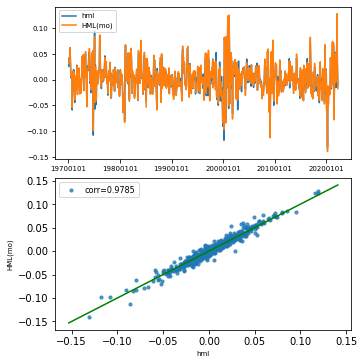

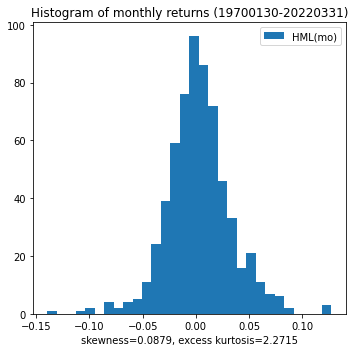

In [8]:
holdings = portfolios['holdings'][label]        
backtest = BackTest(user, bench, 'RF', LAST_DATE, verbose=VERBOSE)
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname], 19700101, LAST_DATE)
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))
          

### Linear regression on Mkt-Rf and intercept

In [9]:
x = bench.get_series('mkt-rf(mo)', start=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

Period: 19640601-20220331
                            OLS Regression Results                            
Dep. Variable:           Q("HML(mo)")   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     8.691
Date:                Tue, 10 Jan 2023   Prob (F-statistic):            0.00332
Time:                        16:19:45   Log-Likelihood:                 1317.4
No. Observations:                 627   AIC:                            -2631.
Df Residuals:                     625   BIC:                            -2622.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

### Plot histogram and comparison of SMB returns

/home/terence/env3.10/lib/python3.10/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of smb vs SMB(mo) (19700130 - 20220331): 0.9804
Period: 19640601-20220331
                            OLS Regression Results                            
Dep. Variable:           Q("SMB(mo)")   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     42.80
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           1.26e-10
Time:                        16:20:01   Log-Likelihood:                 1319.1
No. Observations:                 627   AIC:                            -2634.
Df Residuals:                     625   BIC:                            -2625.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

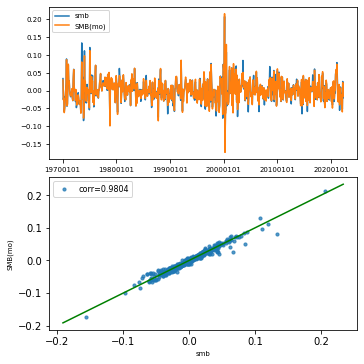

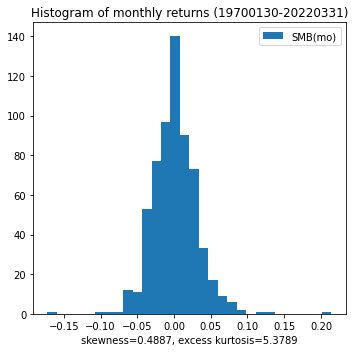

In [10]:
label, benchname = 'smb', 'SMB(mo)'
holdings = portfolios['holdings'][label]
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname], 19700101, LAST_DATE)
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

# Linear regression on Mkt-Rf and intercept
x = bench.get_series('mkt-rf(mo)', start=y.index[0], end=y.index[-1])
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

## Construct MOM signal
- Load monthly universe and stock returns from CRSP.
- Signal is stocks' total return from 12 months ago, skipping most recent month
- Construct 2-way portfolio sorts, and backtest returns

In [11]:
label, benchname, past, leverage = 'mom', 'Mom(mo)', (2,12), 1
rebalbeg, rebalend = 19270101, LAST_DATE

df = DataFrame()      # collect each month's momentum signal values
for rebaldate in tqdm(bd.date_range(rebalbeg, rebalend, 'endmo')):
    beg = bd.endmo(rebaldate, -past[1])   # require price at this date
    start = bd.offset(beg, 1)             # start date, inclusive, of signal
    end = bd.endmo(rebaldate, 1-past[0])  # end date of signal
    p = [crsp.get_universe(rebaldate),    # retrieve prices and construct signal
         crsp.get_ret(start, end).rename(label),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end')]
    q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
    q['rebaldate'] = rebaldate
    df = pd.concat([df, q[['permno', 'rebaldate', label]]], axis=0)
signals.write(df, label, overwrite=True)

100%|███████████████████████████████████████| 1143/1143 [24:30<00:00,  1.29s/it]


3325771

## Construct MOM bivariate portfolio sorts

/home/terence/env3.10/lib/python3.10/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of mom vs Mom(mo) (19270228 - 20220331): 0.9994
Period: 19270101-20220331
                            OLS Regression Results                            
Dep. Variable:           Q("Mom(mo)")   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     4.783
Date:                Tue, 10 Jan 2023   Prob (F-statistic):             0.0291
Time:                        16:54:48   Log-Likelihood:                 1087.2
No. Observations:                 627   AIC:                            -2170.
Df Residuals:                     625   BIC:                            -2161.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

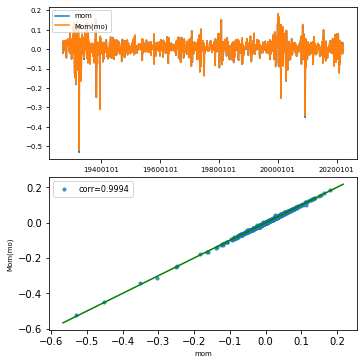

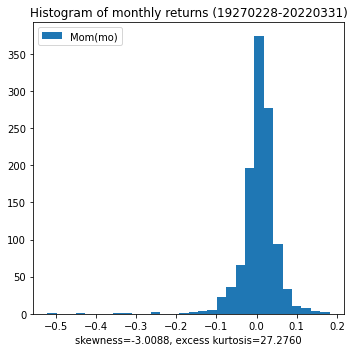

In [12]:
portfolios = famafrench_sorts(stocks=crsp,
                              label=label,
                              signals=signals,
                              rebalbeg=rebalbeg,
                              rebalend=rebalend,
                              window=0,
                              months=[],
                              leverage=leverage)
holdings = portfolios['holdings'][label]
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname])# Plot histogram and comparison of returns

# Plot histogram and comparison of returns
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

# Linear regression on Mkt-Rf and intercept
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())

## Construct STRev signal

100%|███████████████████████████████████████| 1155/1155 [25:21<00:00,  1.32s/it]
/home/terence/env3.10/lib/python3.10/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val


<Correlation of strev vs ST_Rev(mo) (19260227 - 20220331): 0.9983
Period: 19260101-20220331
                            OLS Regression Results                            
Dep. Variable:        Q("ST_Rev(mo)")   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     31.03
Date:                Tue, 10 Jan 2023   Prob (F-statistic):           3.78e-08
Time:                        17:24:53   Log-Likelihood:                 1292.9
No. Observations:                 627   AIC:                            -2582.
Df Residuals:                     625   BIC:                            -2573.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

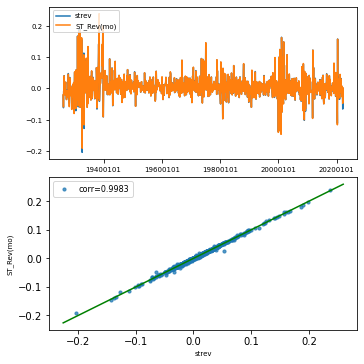

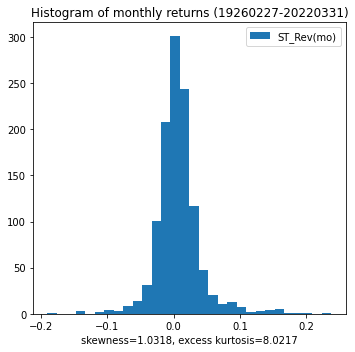

In [13]:
# Signal value is recent month's stock returns, sign flipped
label, benchname, past, leverage = 'strev', 'ST_Rev(mo)', (1,1), -1
rebalbeg, rebalend = 19260101, LAST_DATE   #rebalbeg = 20100101

# loop over each rebalance date to construct and collect signals values 
df = DataFrame()
for rebaldate in tqdm(bd.date_range(rebalbeg, rebalend, 'endmo')):
    beg = bd.endmo(rebaldate, -past[1])   # beg price date of signal
    end = bd.endmo(rebaldate, 1-past[0])  # end price date of signal

    # Retrieve universe, require have prices at beg and end dates,
    # and construct signal as returns compounded between start and end dates
    p = [crsp.get_universe(rebaldate),
         crsp.get_section('monthly', ['prc'], 'date', beg)['prc'].rename('beg'),
         crsp.get_section('monthly', ['prc'], 'date', end)['prc'].rename('end'),
         crsp.get_ret(bd.offset(beg, 1), end).rename(label)]
    q = pd.concat(p, axis=1, join='inner').reset_index().dropna()
    q['rebaldate'] = rebaldate
    df = pd.concat((df, q[['permno','rebaldate', label]]), axis=0)

# Save signals values
signals.write(df, label, overwrite=True)
                  
# Construct bivariate portfolio sorts
portfolios = famafrench_sorts(stocks=crsp,
                              label=label,
                              signals=signals,
                              rebalbeg=rebalbeg,
                              rebalend=rebalend,
                              window=0,
                              months=[],
                              leverage=leverage)
holdings = portfolios['holdings'][label]
result = backtest(crsp, holdings, label)
y = backtest.fit([benchname])

# Plot histogram and comparison of returns
plot_ff(y, label, savefig=imgdir / (label + '.jpg'))
plot_summary(y, benchname, savefig=imgdir / (label + '_hist.jpg'))

# Linear regression on Mkt-Rf and intercept
lm = smf.ols(f'Q("{benchname}")~Q("{x.name}")', data=pd.concat([y, x], axis=1))\
        .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"Period: {rebalbeg}-{rebalend}")
print(lm.summary())